<a href="https://colab.research.google.com/github/KValim/Projetcs/blob/main/Globo/previsao_canais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827#:~:text=Save-,Stock%20Prices%20Prediction%20Using%20Long%20Short,Memory%20(LSTM)%20Model%20in%20Python&text=Long%20Short%2DTerm%20Memory%20(LSTM)%20is%20one%20type%20of,useful%20in%20predicting%20stock%20prices.

In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


            Sales
Date             
2007-01-01  61759
2007-02-01  61965
2007-03-01  61142
2007-04-01  60421
2007-05-01  59727
...           ...
2022-04-01  25220
2022-05-01  24880
2022-06-01  24434
2022-07-01  24157
2022-08-01  24224

[182 rows x 1 columns]
AxesSubplot(0.125,0.2;0.775x0.68)


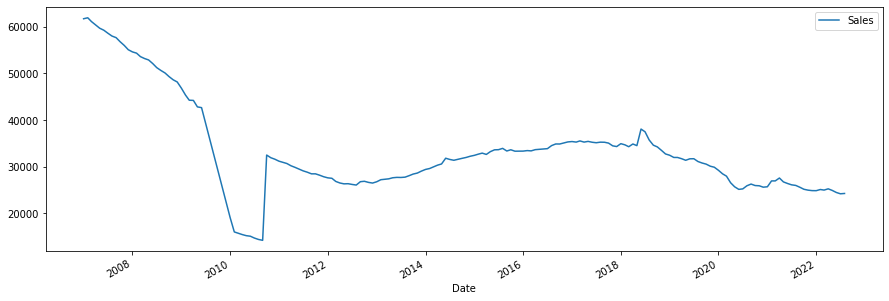

In [ ]:
data = pd.read_excel('OPERADOR.xlsx', header = 2)
# data = data[data['OPERADOR'] == 'COMCAST CABLE COMMUNICATIONS LLC']
data = data[data['OPERADOR'] == 'ECHOSTAR SATELLITE L.L.C.']
data = data.drop(columns='OPERADOR')
data = data.rename(columns = {'Atributo' : 'Date', 'mBaseAssinantesMescla' : 'Sales'})
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
print(data)
print(data.plot(figsize=(15,5)))


            Sales
Date             
2011-01-01  31161
2011-02-01  30901
2011-03-01  30662
2011-04-01  30171
2011-05-01  29835
...           ...
2022-04-01  25220
2022-05-01  24880
2022-06-01  24434
2022-07-01  24157
2022-08-01  24224

[140 rows x 1 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


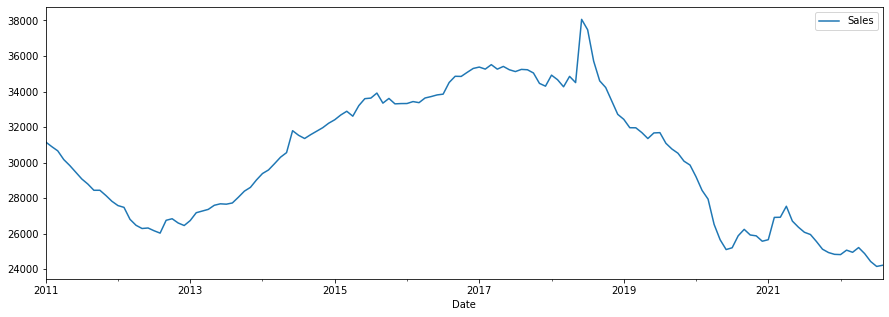

In [ ]:
# comcast
# data = data[3+(12*0):-8] # ajustando a data inicial para começar em janeiro e a final para terminar em dezembro
# data = data.replace(38814,21967) # normalizando o outlier

# echostar
data = data[12*4-6:] # ajustando a data inicial para começar em janeiro e a final para terminar em dezembro
stock_data = data
print(data)
print(data.plot(figsize=(15,5)))



In [ ]:
close_prices = stock_data['Sales']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:

# model = keras.Sequential()
# # model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# # model.add(layers.LSTM(100, return_sequences=False))
# # model.add(layers.Dense(25))
# model.add(layers.LSTM(8, input_shape=(x_train.shape[1], 1), activation='relu'))
# model.add(layers.LSTM(8))
# model.add(layers.Dense(1))
# model.summary()

In [ ]:
epochs = 400
batch = 25
lr = 0.0001
adam = keras.optimizers.Adam(lr)

model = keras.Sequential()
model.add(layers.Dense(100, activation='relu', input_dim=x_train.shape[1]))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=adam, metrics = ['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 100)               6100      
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
Total params: 6,201
Trainable params: 6,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.python import metrics
# model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= batch, epochs=epochs)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1/1 [==============================] - 0s 94ms/step


2092.194405691964

<ipython-input-138-a8f56709cc8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


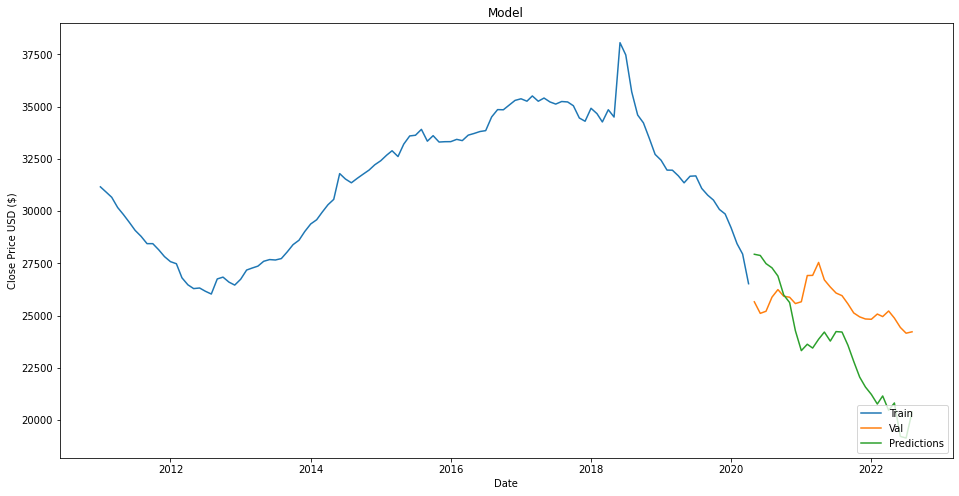

In [ ]:
data = stock_data.filter(['Sales'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Sales', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()